## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read Dataset

In [2]:
data=pd.read_csv('emotion_data.csv')
data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [3]:
data.shape

(16000, 2)

In [4]:
data.isnull().sum()

text     0
label    0
dtype: int64

## Clean the text

In [5]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    return text

In [6]:
data['text']=data['text'].apply(clean_text)

In [7]:
emotion_map={
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

## Mapping the emotion_map to label

In [8]:
data['emotion']=data['label'].map(emotion_map)
data.head()

,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [9]:
data['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

## Distibution of emotions

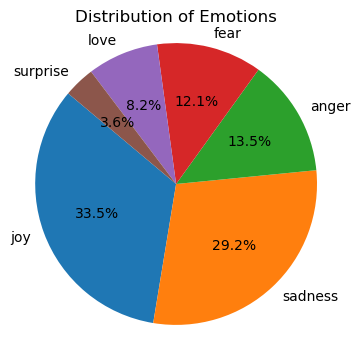

In [10]:
import matplotlib.pyplot as plt
label_counts = data['emotion'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotions')
plt.axis('equal')  
plt.show()

## Preprocessing the text

In [11]:
def preprocess_text_nltk(text):
    tokens = word_tokenize(text.lower())  
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    processed_text = ' '.join(tokens)
    
    return processed_text

In [12]:
data['text']=data['text'].apply(preprocess_text_nltk)

In [13]:
data.head()

,text,label,emotion
0,didnt feel humili,0,sadness
1,go feel hopeless damn hope around someon care ...,0,sadness
2,im grab minut post feel greedi wrong,3,anger
3,ever feel nostalg fireplac know still properti,2,love
4,feel grouchi,3,anger


## Splitting data into traing and testing data

In [14]:
X=data['text']
y=data['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Feature Extraction

In [15]:
from sklearn import preprocessing 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [16]:
tfidf=TfidfVectorizer(ngram_range=(1,2),min_df=10)
tfidf.fit(X_train)

x_train_tfidf=tfidf.transform(X_train)
x_test_tfidf=tfidf.transform(X_test)

x_train_tfidf=preprocessing.normalize(x_train_tfidf)
print("train data size: ",x_train_tfidf.shape)

x_test_tfidf=preprocessing.normalize(x_test_tfidf)
print("Test data size: ",x_test_tfidf.shape)

train data size:  (12800, 2220)
Test data size:  (3200, 2220)


## MultinomialNB Model

In [17]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier=MultinomialNB()
nb_classifier.fit(x_train_tfidf,y_train)

MultinomialNB()

In [18]:
y_pred_nb=nb_classifier.predict(x_test_tfidf)

In [19]:
print("Naive Bayes classifier results:")
print(f"Accuracy :{accuracy_score(y_test,y_pred_nb)}")
print("Classification report:")
print(classification_report(y_test,y_pred_nb)) 
print("Confusion Matrix :")
print(confusion_matrix(y_test,y_pred_nb))

Naive Bayes classifier results:
Accuracy :0.7921875
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       946
           1       0.70      0.98      0.82      1021
           2       0.96      0.32      0.48       296
           3       0.90      0.69      0.78       427
           4       0.86      0.64      0.74       397
           5       0.88      0.19      0.32       113

    accuracy                           0.79      3200
   macro avg       0.86      0.62      0.67      3200
weighted avg       0.82      0.79      0.77      3200

Confusion Matrix :
[[869  61   1   8   7   0]
 [ 16 998   3   2   1   1]
 [ 30 163  94   7   2   0]
 [ 48  74   0 296   9   0]
 [ 51  72   0  16 256   2]
 [ 20  48   0   0  23  22]]


## XGBoost Classifier

In [20]:
from xgboost import XGBClassifier
xgb_classifier=XGBClassifier()
xgb_classifier.fit(x_train_tfidf,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [21]:
y_pred_xgb=xgb_classifier.predict(x_test_tfidf)

In [22]:
print("XGBoost classifier results:")
print(f"Accuracy :{accuracy_score(y_test,y_pred_xgb)}")
print("Classification report:")
print(classification_report(y_test,y_pred_xgb))
print("Confusion Matrix :")
print(confusion_matrix(y_test,y_pred_xgb))

XGBoost classifier results:
Accuracy :0.8590625
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       946
           1       0.83      0.91      0.87      1021
           2       0.80      0.72      0.76       296
           3       0.84      0.84      0.84       427
           4       0.84      0.85      0.85       397
           5       0.78      0.75      0.77       113

    accuracy                           0.86      3200
   macro avg       0.84      0.82      0.83      3200
weighted avg       0.86      0.86      0.86      3200

Confusion Matrix :
[[826  61   8  29  19   3]
 [ 17 928  42  16  10   8]
 [  4  69 213   4   4   2]
 [ 23  29   2 360  13   0]
 [  8  19   2  20 337  11]
 [  1   9   0   1  17  85]]


## Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier()
DT.fit(x_train_tfidf,y_train)

DecisionTreeClassifier()

In [24]:
y_pred_dt=DT.predict(x_test_tfidf)

In [25]:
print("Decision tree classifier results:")
print(f"Accuracy :{accuracy_score(y_test,y_pred_dt)}")
print("Classification report:")
print(classification_report(y_test,y_pred_dt))
print("Confusion Matrix :")
print(confusion_matrix(y_test,y_pred_dt))

Decision tree classifier results:
Accuracy :0.8109375
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       946
           1       0.82      0.83      0.82      1021
           2       0.73      0.70      0.72       296
           3       0.79      0.79      0.79       427
           4       0.79      0.83      0.81       397
           5       0.72      0.59      0.65       113

    accuracy                           0.81      3200
   macro avg       0.78      0.77      0.77      3200
weighted avg       0.81      0.81      0.81      3200

Confusion Matrix :
[[811  52   7  45  28   3]
 [ 70 843  61  20  17  10]
 [  9  68 207   6   5   1]
 [ 33  34   6 337  16   1]
 [ 18  16   1  21 330  11]
 [  4  19   1   0  22  67]]


## Save the model

In [26]:
import joblib
joblib.dump(xgb_classifier, 'xgb_emotion_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## Predicting the result

In [28]:
model = joblib.load('xgb_emotion_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
text = ["This is terrible"]
text_vectorized = vectorizer.transform(text)
prediction = model.predict(text_vectorized)
predicted_emotion = emotion_map[prediction[0]]  
print("Emotion:",predicted_emotion)

Emotion: anger
